In [1]:
import os
import numpy as np
import torchvision.models as models
from PIL import Image
import matplotlib.pyplot as plt


import torch
import torchvision
import torchinfo
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.io import read_image
from torchvision.transforms import functional as TVF
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split
from tqdm import tqdm
from torchinfo import summary


data_dir = "MY_data"
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda


In [2]:
train_transform = transforms.Compose([
    transforms.Resize((40, 40)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),  # Reduced rotation angle
    transforms.ToTensor(),
])

trainset = ImageFolder(data_dir + "/train", transform=train_transform)

train_size = int(0.8 * len(trainset)) 
val_size = len(trainset) - train_size 

trainSubset, valSubset = random_split(trainset, [train_size, val_size])

train_loader = DataLoader(trainSubset, batch_size=64, shuffle=True)
val_loader = DataLoader(valSubset, batch_size=64, shuffle=False)

num_classes = len(trainset.classes)
print(f'Number of classes: {num_classes}')

Number of classes: 10


In [3]:
import matplotlib.pyplot as plt

def plot_training_results(train_losses, val_losses, train_accuracies, val_accuracies):
    
    epochs = range(1, len(train_losses) + 1)

    # Plotting loss
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plotting accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Training Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.show()


In [4]:
def train(net, trainloader, valloader, device, num_epochs, lr=0.01, momentum=0.8, step_size=5, gamma=0.1, verbose=True):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    loss_iterations = int(np.ceil(len(trainloader) / 3))
    
    # Transfer model to GPU
    net = net.to(device)

    # Set the optimizer using the lr and momentum settings passed by the user
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

    for epoch in range(num_epochs):
        running_loss = 0
        running_corrects = 0
        total_samples = 0

        # Training phase
        net.train()  # Ensure the model is in training mode
        for i, (inputs, labels) in enumerate(trainloader):
            optimizer.zero_grad()

            # Transfer data to GPU
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward propagation to get outputs
            outputs = net(inputs)

            # Compute loss
            loss = F.cross_entropy(outputs, labels)

            # Backpropagation to get gradients of all parameters
            loss.backward()

            # Update parameters
            optimizer.step()

            # Accumulate loss
            running_loss += loss.item() * inputs.size(0)

            # Calculate accuracy for the batch
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels)
            total_samples += inputs.size(0)

        # Calculate average training loss and accuracy
        train_loss = running_loss / total_samples
        train_acc = running_corrects.float() / total_samples
        train_losses.append(train_loss)
        train_accuracies.append(train_acc.cpu().numpy())

        # Validation phase
        net.eval()  # Set model to evaluation mode
        val_loss = 0
        val_corrects = 0
        val_samples = 0

        with torch.no_grad():  # Disable gradient computation
            for inputs, labels in valloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = net(inputs)
                loss = F.cross_entropy(outputs, labels)

                val_loss += loss.item() * inputs.size(0)

                _, preds = torch.max(outputs, 1)
                val_corrects += torch.sum(preds == labels)
                val_samples += inputs.size(0)

        val_loss /= val_samples
        val_acc = val_corrects.double() / val_samples
        val_losses.append(val_loss)
        val_accuracies.append(val_acc.cpu().numpy())

        print(f'[Epoch {epoch+1:2d}]: train_loss = {train_loss:.4f}, train_acc = {train_acc:.4f}, '
              f'validation_loss = {val_loss:.4f}, validation_acc = {val_acc:.4f}')

        scheduler.step()  # Step the learning rate scheduler

    print("Training completed.")
    return train_losses, val_losses, train_accuracies, val_accuracies

In [5]:
import torch
from sklearn.metrics import precision_score, recall_score, f1_score

def evaluate(net, dataloader, device):
    net.eval()  # Set model to evaluation mode
    all_targets = []
    all_predictions = []

    with torch.no_grad():  # Disable gradient computation
        for inputs, targets in dataloader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = net(inputs)
            _, predicted = torch.max(outputs, 1)  # Extract the predicted class indices
            
            all_targets.extend(targets.cpu().numpy())  # Store the true labels
            all_predictions.extend(predicted.cpu().numpy())  # Store the predicted labels

    # Calculate accuracy
    accuracy = sum(np.array(all_predictions) == np.array(all_targets)) / len(all_targets)
    print(f'Accuracy: {accuracy:.4f}')
    
    # Calculate Precision, Recall, and F1-Score
    precision = precision_score(all_targets, all_predictions, average='weighted')
    recall = recall_score(all_targets, all_predictions, average='weighted')
    f1 = f1_score(all_targets, all_predictions, average='weighted')

    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1-Score: {f1:.4f}')

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimplifiedModel(nn.Module):
    def __init__(self):
        super(SimplifiedModel, self).__init__()

        # Convolutional Layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.batchnorm1 = nn.BatchNorm2d(32)
        
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.batchnorm2 = nn.BatchNorm2d(64)
        self.dropout1 = nn.Dropout(0.4)
        
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.batchnorm3 = nn.BatchNorm2d(128)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.dropout2 = nn.Dropout(0.5)

        self.fc1 = nn.Linear(128, 64)
        self.batchnorm4 = nn.BatchNorm1d(64)
        self.dropout3 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.batchnorm1(x)
        
        x = F.relu(self.conv3(x))
        x = self.batchnorm2(x)
        x = self.pool(x)
        x = self.dropout1(x)
        
        x = F.relu(self.conv4(x))
        x = self.batchnorm3(x)
        x = self.avgpool(x)
        
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.batchnorm4(x)
        x = self.dropout3(x)
        x = self.fc2(x)
    
        return x

net = SimplifiedModel()

from torchinfo import summary
summary(net, input_size=(64, 3, 40, 40))


Layer (type:depth-idx)                   Output Shape              Param #
SimplifiedModel                          [64, 10]                  --
├─Conv2d: 1-1                            [64, 16, 40, 40]          448
├─Conv2d: 1-2                            [64, 32, 40, 40]          4,640
├─MaxPool2d: 1-3                         [64, 32, 20, 20]          --
├─BatchNorm2d: 1-4                       [64, 32, 20, 20]          64
├─Conv2d: 1-5                            [64, 64, 20, 20]          18,496
├─BatchNorm2d: 1-6                       [64, 64, 20, 20]          128
├─MaxPool2d: 1-7                         [64, 64, 10, 10]          --
├─Dropout: 1-8                           [64, 64, 10, 10]          --
├─Conv2d: 1-9                            [64, 128, 10, 10]         73,856
├─BatchNorm2d: 1-10                      [64, 128, 10, 10]         256
├─AdaptiveAvgPool2d: 1-11                [64, 128, 1, 1]           --
├─Linear: 1-12                           [64, 64]                  8,25

In [7]:
# class NeuralNetwork(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.conv1 = nn.Conv2d(in_channels=3, out_channels=13, kernel_size=5, padding=1)
#         self.act1 = nn.ReLU()
#         self.pool1 = nn.AvgPool2d(kernel_size=3, stride=2)
        
#         self.conv2 = nn.Conv2d(in_channels=13, out_channels=27, kernel_size=5, padding=1)
#         self.act2 = nn.ReLU()
#         self.pool2 = nn.AvgPool2d(kernel_size=3, stride=2)
        
#         #6250
#         self.fc1 = nn.Linear(1323, 3100)

#         self.act3 = nn.ReLU()
        
#         self.fc2 = nn.Linear(3100, 400)
#         self.act4 = nn.Sigmoid()
        
#         self.fc3 = nn.Linear(400, 10)
        
        
#     def forward(self, x):
        
#         x = self.conv1(x)
#         x = self.act1(x)
#         x = self.pool1(x)
        
#         x = self.conv2(x)
#         x = self.act2(x)
#         x = self.pool2(x)  
        
        
#         x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))
#         x = self.fc1(x)
#         x = self.act3(x)
        
#         x = self.fc2(x)
#         x = self.act4(x)
        
#         x = self.fc3(x)
#         return x

# net = NeuralNetwork()
# summary(net, input_size=(64, 3, 40, 40))


In [8]:
train_losses, val_losses, train_accuracies, val_accuracies = train(net, train_loader, val_loader, device, num_epochs=30, lr=0.001, step_size=5, gamma=0.1)

[Epoch  1]: train_loss = 2.2507, train_acc = 0.1946, validation_loss = 2.2952, validation_acc = 0.1215
[Epoch  2]: train_loss = 2.0178, train_acc = 0.2739, validation_loss = 2.0116, validation_acc = 0.2516
[Epoch  3]: train_loss = 1.8708, train_acc = 0.3179, validation_loss = 1.8602, validation_acc = 0.3037
[Epoch  4]: train_loss = 1.8056, train_acc = 0.3386, validation_loss = 1.7461, validation_acc = 0.3601
[Epoch  5]: train_loss = 1.7143, train_acc = 0.3853, validation_loss = 1.6696, validation_acc = 0.3753
[Epoch  6]: train_loss = 1.6973, train_acc = 0.3897, validation_loss = 1.6674, validation_acc = 0.3883
[Epoch  7]: train_loss = 1.6352, train_acc = 0.4098, validation_loss = 1.6546, validation_acc = 0.3926
[Epoch  8]: train_loss = 1.6544, train_acc = 0.4114, validation_loss = 1.6484, validation_acc = 0.3991
[Epoch  9]: train_loss = 1.6485, train_acc = 0.4179, validation_loss = 1.6415, validation_acc = 0.4230
[Epoch 10]: train_loss = 1.6268, train_acc = 0.4158, validation_loss = 1.

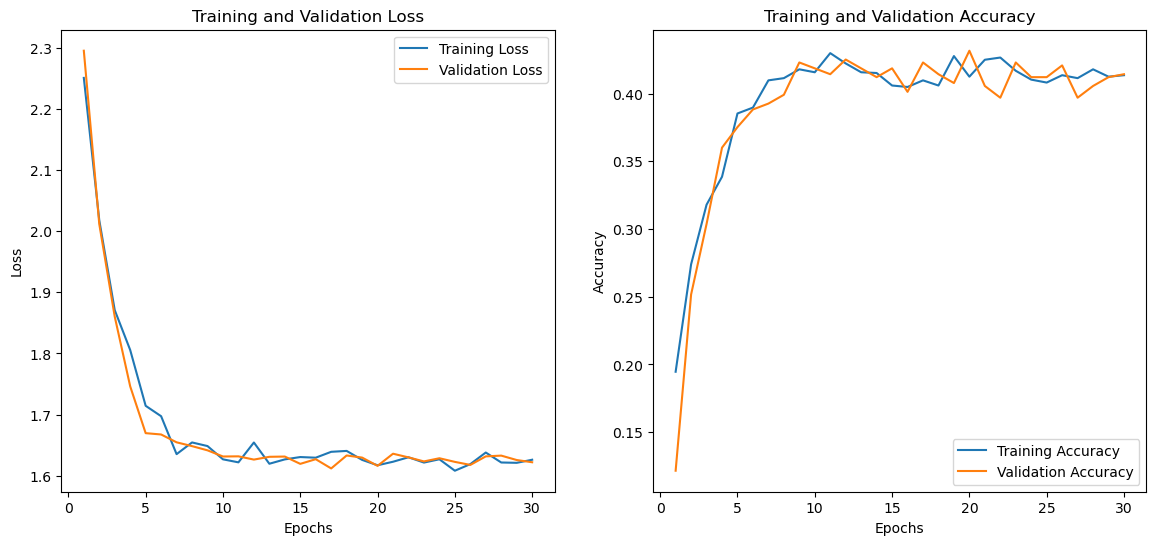

In [9]:
plot_training_results(train_losses, val_losses, train_accuracies, val_accuracies)

In [10]:
test_transform = transforms.Compose([
    transforms.Resize((40, 40)),
    transforms.ToTensor(),
])

testset = ImageFolder(data_dir + "/Test", transform=test_transform)
test_loader = DataLoader(testset, batch_size=64, shuffle=False)
evaluate(net, test_loader, device)

Accuracy: 0.3854
Precision: 0.4093
Recall: 0.3854
F1-Score: 0.3496


In [11]:
def predict_image(image_path, model, transform=None):
    model.eval()
    
    device = next(model.parameters()).device
    
    image = Image.open(image_path)
    
    img = transform(image)
    
    img = img.to(device)
    
    xb = img.unsqueeze(0)
    
    with torch.no_grad():
        yb = model(xb)
        
    _, preds = torch.max(yb, dim=1)
    
    return preds.item()